###**Loading the Dataset from Kaggle**

In [ ]:
!nvidia-smi

Sun Jun  9 19:41:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'leukemia-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F849724%2F1449674%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240609%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240609T170441Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6fea0ce5d48fbf61f8c04063b67831dad2cd139bd7defd2e76994facfcd1bf72d4598eb6a69a2a0aa693c51b2aba2cb8a186322740bbfb16ddd34fe44eae2203d18777cf5fee4f3f814fbcfb716d635db5a24f4a937cfb313214a3ad73d37871d9cdc83be4cb2121bce9ccea4f439c684ecbf9532542897bc3e857b788d2686cb2b2ac0f234644b61a5727a6667d327bf700d5a109b028df2dc2dba2925bb5903d61b293077e34c87b207d4c324a9e034d0b883c7e68e15739608cd8a2e73213e8cd5ae7c703046b02efae07972914fc96cb017fe03fd908ef35c05140e7e6184558446df5990bfbb37e2490b700ce80e19e66e2bb436272faf86c9f0ca95c85'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 909211078 bytes downloaded
Downloaded and uncompressed: leukemia-classification
Data source import complete.


###**Loading The Modules**

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


###**Functions to create Dataframe and generate data**

In [ ]:
# Generate data paths with labels
def create_df(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)

        for fold_ in filelist:
            foldpath_ = os.path.join(foldpath, fold_)
            filelist_ = os.listdir(foldpath_)

            for file_ in filelist_:
                fpath = os.path.join(foldpath_, file_)
                filepaths.append(fpath)
                labels.append(fold_)

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df =  pd.concat([Fseries, Lseries], axis= 1)

    strat = df['labels']
    train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=123, stratify=strat)
    strat = dummy_df['labels']
    valid_df, test_df= train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

    return train_df, valid_df, test_df


In [ ]:
def create_model_data (train_df, valid_df, test_df, batch_size):

    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

###**Loading the dataset**

In [ ]:
data_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data'

try:
    # Get splitted data
    train_df, valid_df, test_df = create_df(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 7462 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.


###**Displaying Images**

In [ ]:
def show_images(gen):
    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

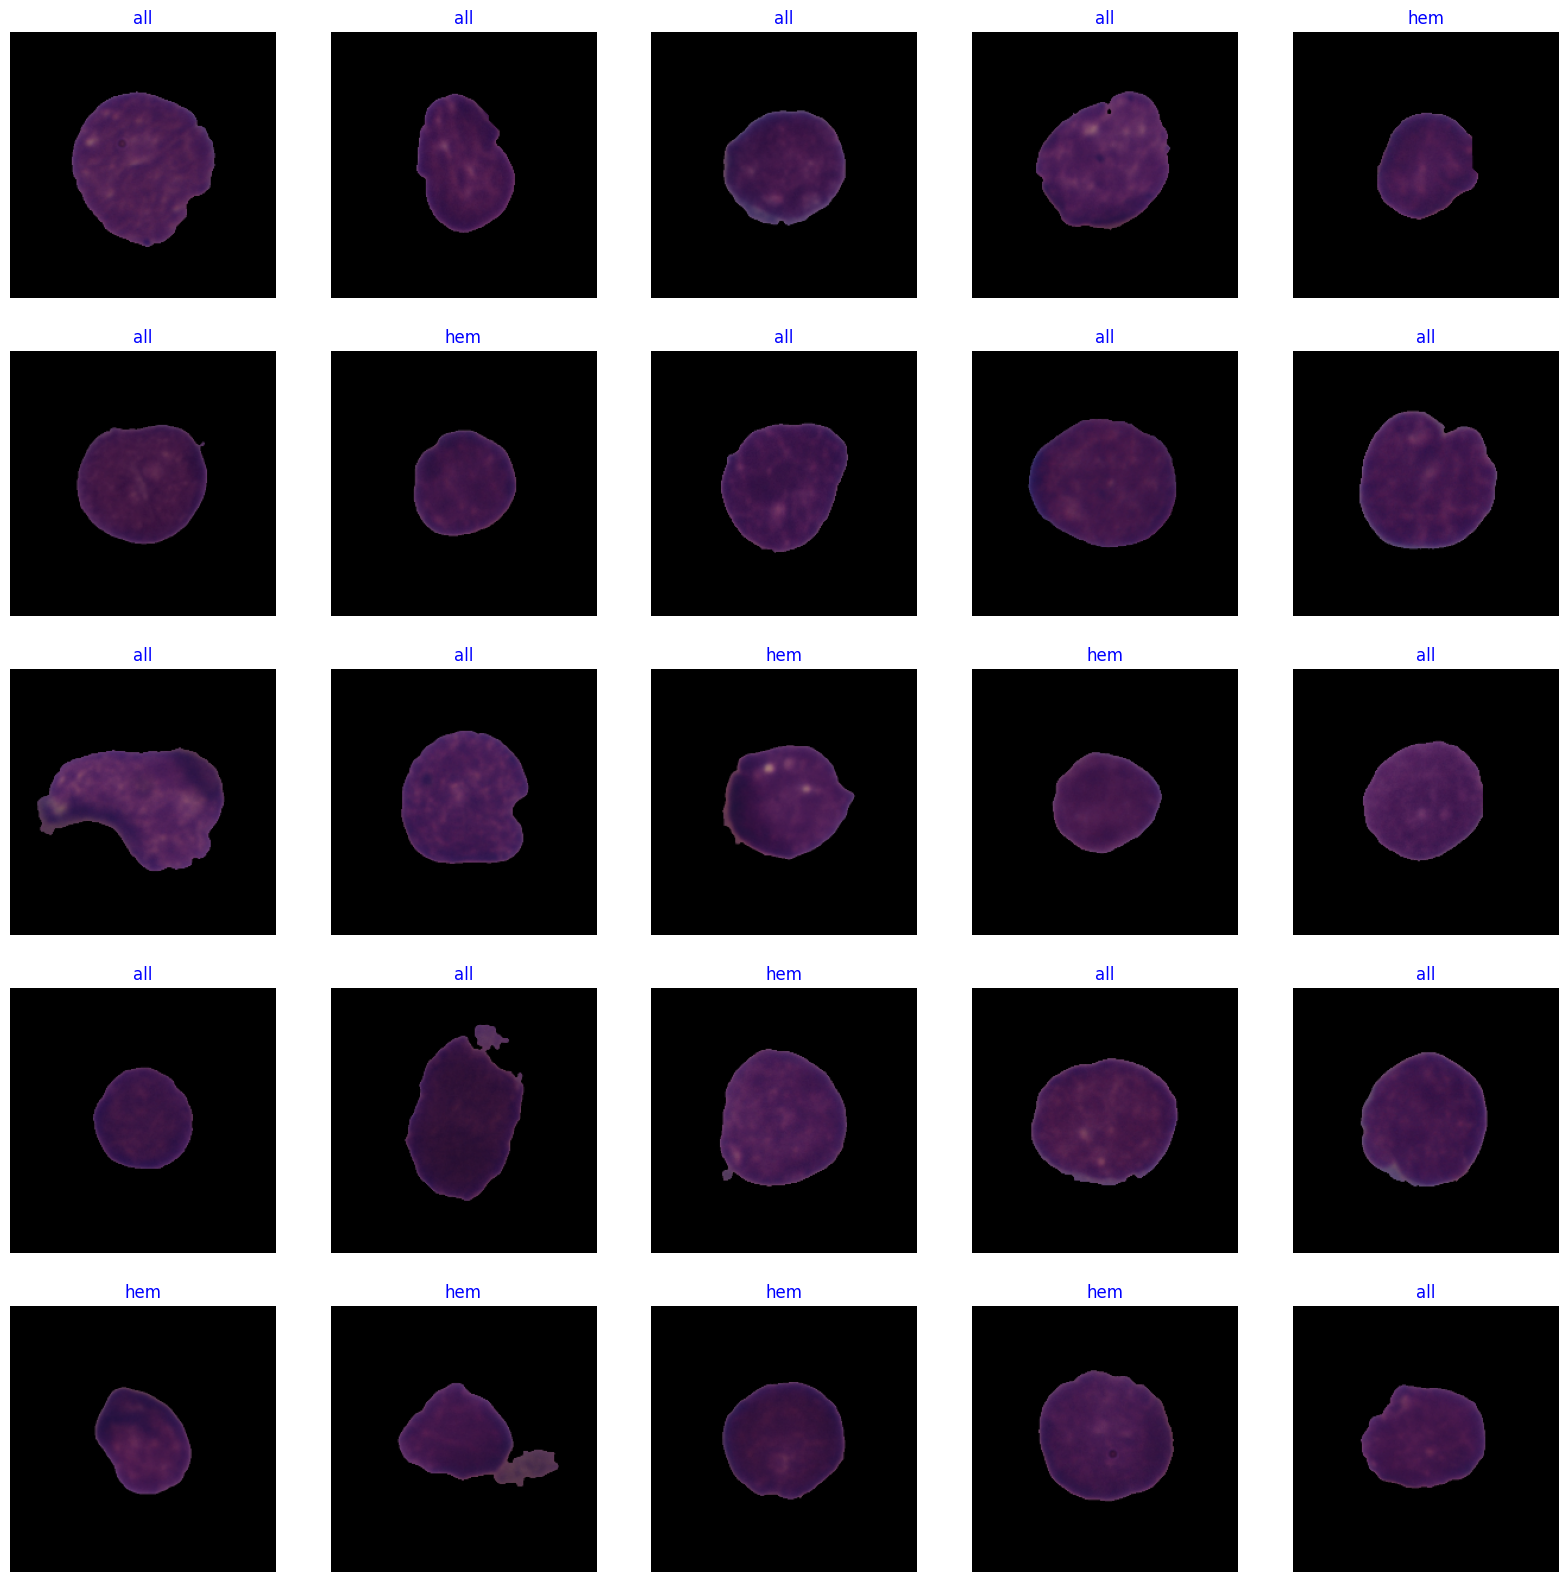

In [ ]:
show_images(train_gen)

###**Creating a Callback Class to monitor Training**

In [ ]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

###**Creating Model 01: EfficientNetB3 Model**

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                         

**Defining Call back**

In [ ]:
batch_size = 40   # set batch size for training
epochs = 40   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 3   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

**Training model**

In [ ]:
history1 = model.fit(x= train_gen, epochs= epochs, verbose= 1, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?
y
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
Epoch 1/40
187/187 [==============================] - 196s 719ms/step - loss: 5.3791 - accuracy: 0.7987 - val_loss: 3.8876 - val_accuracy: 0.8268
Epoch 2/40
187/187 [==============================] - 125s 670ms/step - loss: 2.7695 - accuracy: 0.8835 - val_loss: 2.6142 - val_accuracy: 0.8180
Epoch 3/40
187/187 [==============================] - ETA: 0s - loss: 1.7510 - accuracy: 0.9109 3 /40     1.751   91.088   1.45917  88.931   0.00100  0.00100  val_loss    44.18    121.20 
enter H to halt training or an integer for number of epochs to run then ask again
5
 training will continue until epoch 8
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
187/187 [==============================] - 126s 673ms/step - loss: 1.7510 - accuracy: 0.9109 - val_loss: 1.4592 - val_accuracy: 0.8893
Epoch 4/40
187/187 [=

**Saving model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save('/content/drive/MyDrive/ALL_MINI_Folder/Efficient_netb3/efficientnetb3_model1.h5')

model.save_weights("/content/drive/MyDrive/ALL_MINI_Folder/Efficient_netb3/efficientnetb3_weights1.h5")

In [ ]:
model1 = tf.keras.models.load_model('/content/drive/MyDrive/ALL_MINI_Folder/Efficient_netb3/efficientnetb3_model1.h5')

###**Creating Model 02: RESNET Model**

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Number of classes in dense layer

# Create pre-trained model using ResNet50
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 24120962 (92.01 MB)
Trainable params: 24063

**Defining call back**

In [ ]:
batch_size = 40   # set batch size for training
epochs = 40   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 3   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

**Training the model 2**

In [ ]:
history2 = model.fit(x=train_gen, epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=valid_gen, validation_steps=None, shuffle=False)

Do you want model asks you to halt the training [y/n] ?
y
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
Epoch 1/40
  6/187 [..............................] - ETA: 1:20 - loss: 9.0879 - accuracy: 0.6625

187/187 [==============================] - 139s 509ms/step - loss: 5.4263 - accuracy: 0.8248 - val_loss: 4.3502 - val_accuracy: 0.6979
Epoch 2/40
187/187 [==============================] - 92s 493ms/step - loss: 3.0343 - accuracy: 0.8920 - val_loss: 2.7631 - val_accuracy: 0.7530
Epoch 3/40
187/187 [==============================] - ETA: 0s - loss: 2.0446 - accuracy: 0.9094 3 /40     2.045   90.941   1.73826  89.056   0.00100  0.00100  val_loss    37.09    87.61  
enter H to halt training or an integer for number of epochs to run then ask again
5
 training will continue until epoch 8
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
187/187 [==============================] - 134s 715ms/step - loss: 2.0446 - accuracy: 0.9094 - val_loss: 1.7383 - val_accuracy: 0.8906
Epoch 4/40
187/187 [==============================] - 87s 467ms/step - loss: 1.4384 - accuracy: 0.9132 - val_loss: 1.2720 - val_accuracy: 0.8881
Epoch 5/40
187/187 [==================

**Saving the model2**

In [ ]:
model.save('/content/drive/MyDrive/ALL_MINI_Folder/ResNet50/ResNet50_model2.h5')

model.save_weights("/content/drive/MyDrive/ALL_MINI_Folder/ResNet50/ResNet50_weights2.h5")

In [ ]:
model2 = tf.keras.models.load_model('/content/drive/MyDrive/ALL_MINI_Folder/ResNet50/ResNet50_model2.h5')

###**Creating Model 03:VGG Model**

In [ ]:
from tensorflow.keras.applications import VGG16

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Number of classes in dense layer

# Create pre-trained model using VGG16
base_model = VGG16(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization_2 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 

In [ ]:
batch_size = 40   # set batch size for training
epochs = 40   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 3   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [ ]:
history3 = model.fit(x=train_gen, epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=valid_gen, validation_steps=None, shuffle=False)

Do you want model asks you to halt the training [y/n] ?
y
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
Epoch 1/40
  6/187 [..............................] - ETA: 1:37 - loss: 6.7590 - accuracy: 0.5750

187/187 [==============================] - 158s 685ms/step - loss: 3.8290 - accuracy: 0.7893 - val_loss: 3.6868 - val_accuracy: 0.7036
Epoch 2/40
187/187 [==============================] - 109s 583ms/step - loss: 1.9050 - accuracy: 0.8116 - val_loss: 2.0845 - val_accuracy: 0.6323
Epoch 3/40
187/187 [==============================] - ETA: 0s - loss: 1.2053 - accuracy: 0.8277 3 /40     1.205   82.766   2.32306  31.770   0.00100  0.00100  accuracy     1.98    109.34 
enter H to halt training or an integer for number of epochs to run then ask again
7
 training will continue until epoch 10
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
187/187 [==============================] - 117s 627ms/step - loss: 1.2053 - accuracy: 0.8277 - val_loss: 2.3231 - val_accuracy: 0.3177
Epoch 4/40
187/187 [==============================] - 106s 566ms/step - loss: 0.8331 - accuracy: 0.8551 - val_loss: 2.4469 - val_accuracy: 0.3177
Epoch 5/40
187/187 [===============

In [ ]:
model.save('/content/drive/MyDrive/ALL_MINI_Folder/VGG16/vgg16_model3.h5')

model.save_weights("/content/drive/MyDrive/ALL_MINI_Folder/VGG16/vgg16_weights3.h5")

In [ ]:
model3 = tf.keras.models.load_model('/content/drive/MyDrive/ALL_MINI_Folder/VGG16/vgg16_model3.h5')

###**Creating Model 04:AlexNet**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Number of classes in dense layer

model = Sequential([
    Conv2D(96, (11, 11), strides=(4, 4), input_shape=img_shape, activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    BatchNormalization(),

    Conv2D(256, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    BatchNormalization(),

    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    BatchNormalization(),

    Flatten(),

    Dense(4096, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),

    Dense(4096, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),

    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 batch_normalization_3 (Bat  (None, 26, 26, 96)        384       
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                      

In [ ]:
batch_size = 40   # set batch size for training
epochs = 40   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 3   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [ ]:
history4 = model.fit(x=train_gen, epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=valid_gen, validation_steps=None, shuffle=False)

Do you want model asks you to halt the training [y/n] ?
y
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
Epoch 1/40
187/187 [==============================] - 31s 128ms/step - loss: 0.8767 - accuracy: 0.7238 - val_loss: 1.3563 - val_accuracy: 0.7111
Epoch 2/40
187/187 [==============================] - 23s 121ms/step - loss: 0.5786 - accuracy: 0.7667 - val_loss: 0.4979 - val_accuracy: 0.7967
Epoch 3/40
 3 /40     0.545   77.057   0.46809  79.800   0.00100  0.00100  accuracy     0.51    23.76  
enter H to halt training or an integer for number of epochs to run then ask again
5
 training will continue until epoch 8
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
187/187 [==============================] - 200s 1s/step - loss: 0.5447 - accuracy: 0.7706 - val_loss: 0.4681 - val_accuracy: 0.7980
Epoch 4/40
 4 /40     0.499   79.456   2.01616  32.333   0.00100  0.00100  accuracy     3.11    20.16  
187/18

In [ ]:
model.save('/content/drive/MyDrive/ALL_MINI_Folder/AlexNet/alexnet_model4.h5')

model.save_weights("/content/drive/MyDrive/ALL_MINI_Folder/AlexNet/alexnet_weights4.h5")

In [ ]:
model4 = tf.keras.models.load_model('/content/drive/MyDrive/ALL_MINI_Folder/AlexNet/alexnet_model4.h5')

###**Functions for Plotting and Analysis**

In [ ]:
def plot_training(hist):
    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

###**Saving History**

**Model 01 - EfficientNetB3**

In [ ]:
import json
with open('/content/drive/MyDrive/ALL_MINI_Folder/Efficient_netb3/training_history1.json', 'w') as f:
    json.dump(history1.history, f)

**Model 02 - ResNet50**

In [ ]:
with open('/content/drive/MyDrive/ALL_MINI_Folder/ResNet50/training_history2.json', 'w') as f:
    json.dump(history2.history, f)

**Model 03 - VGG16**

In [ ]:
with open('/content/drive/MyDrive/ALL_MINI_Folder/VGG16/training_history3.json', 'w') as f:
    json.dump(history3.history, f)

**Model 04 - AlexNet**

In [ ]:
with open('/content/drive/MyDrive/ALL_MINI_Folder/AlexNet/training_history4.json', 'w') as f:
    json.dump(history4.history, f)

###**Plotting History**

**Model 01 - EfficientNetB3**

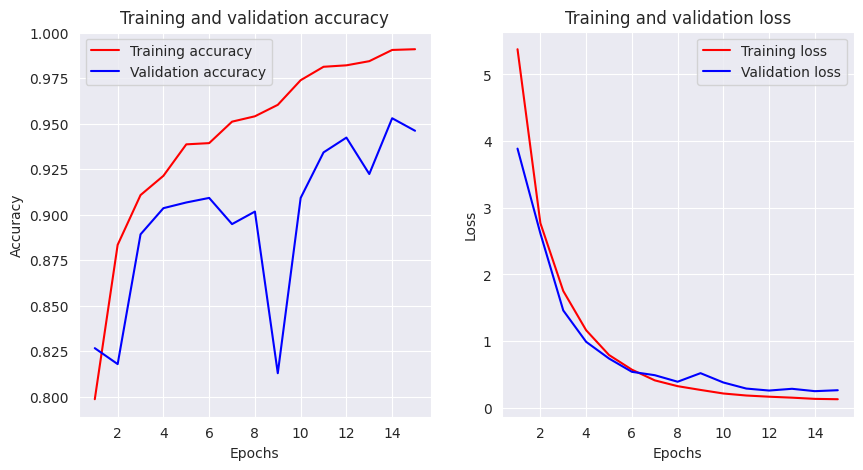

In [ ]:
import json
import matplotlib.pyplot as plt

# Load history from JSON file
with open('/content/drive/MyDrive/ALL_MINI_Folder/Efficient_netb3/training_history1.json', 'r') as f:
    history = json.load(f)

# Extract training and validation metrics from the loaded dictionary
tr_acc = history['accuracy']
tr_loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

# Plot training history
epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


**Model 02 - ResNet50**

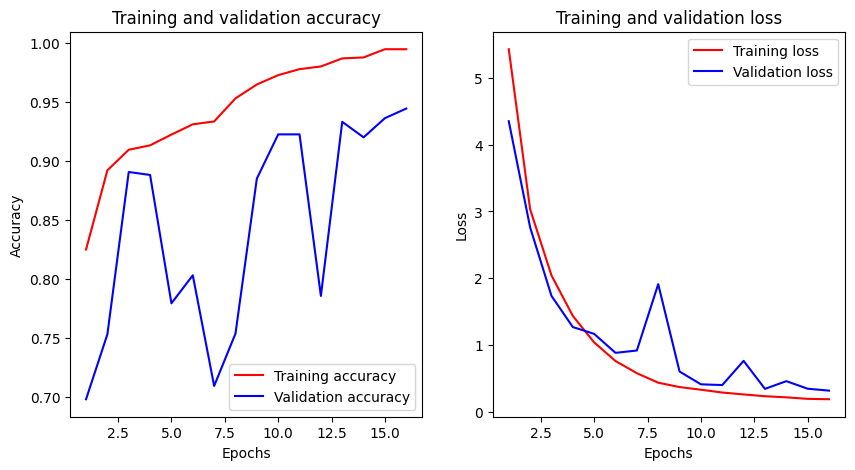

In [ ]:
import json
import matplotlib.pyplot as plt

# Load history from JSON file
with open('/content/drive/MyDrive/ALL_MINI_Folder/ResNet50/training_history2.json', 'r') as f:
    history = json.load(f)

# Extract training and validation metrics from the loaded dictionary
tr_acc = history['accuracy']
tr_loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

# Plot training history
epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


**Model 03 - VGG16**

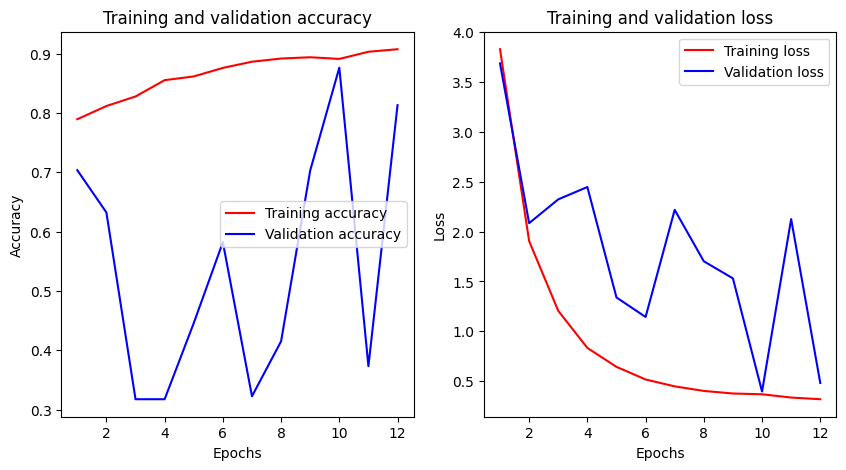

In [ ]:
import json
import matplotlib.pyplot as plt

# Load history from JSON file
with open('/content/drive/MyDrive/ALL_MINI_Folder/VGG16/training_history3.json', 'r') as f:
    history = json.load(f)

# Extract training and validation metrics from the loaded dictionary
tr_acc = history['accuracy']
tr_loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

# Plot training history
epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


**Model 04 - AlexNet**

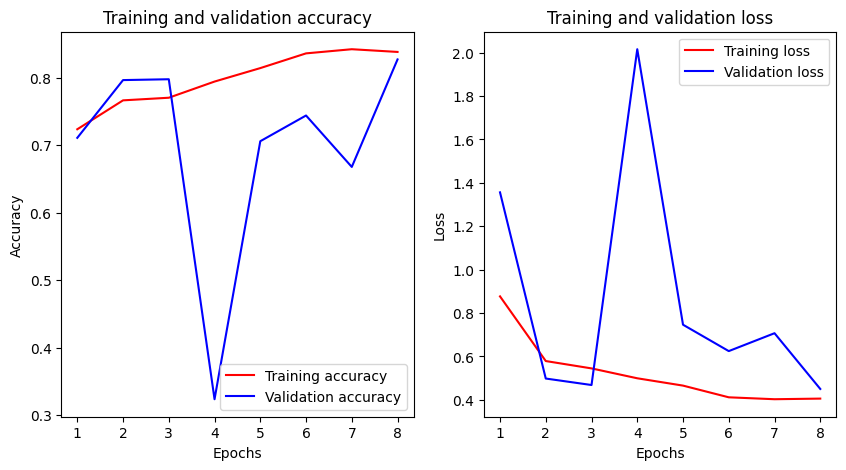

In [ ]:
import json
import matplotlib.pyplot as plt

# Load history from JSON file
with open('/content/drive/MyDrive/ALL_MINI_Folder/AlexNet/training_history4.json', 'r') as f:
    history = json.load(f)

# Extract training and validation metrics from the loaded dictionary
tr_acc = history['accuracy']
tr_loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

# Plot training history
epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


###**Evalute Models**

**Model 01:EfficientNetb3**

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model1.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model1.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model1.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

20/20 [==============================] - 12s 423ms/step - loss: 0.2099 - accuracy: 0.9613
Train Loss:  0.09202466905117035
Train Accuracy:  0.9987499713897705
--------------------
Validation Loss:  0.2448410838842392
Validation Accuracy:  0.9474999904632568
--------------------
Test Loss:  0.20989249646663666
Test Accuracy:  0.9612500071525574


**model 02:ResNet50**

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model2.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model2.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model2.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

20/20 [==============================] - 9s 251ms/step - loss: 0.3118 - accuracy: 0.9438
Train Loss:  0.1735975593328476
Train Accuracy:  0.9987499713897705
--------------------
Validation Loss:  0.29426273703575134
Validation Accuracy:  0.949999988079071
--------------------
Test Loss:  0.31184685230255127
Test Accuracy:  0.9437500238418579


**Model 03: VGG16**

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model3.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model3.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model3.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

20/20 [==============================] - 19s 295ms/step - loss: 1.5245 - accuracy: 0.7094
Train Loss:  1.5134530067443848
Train Accuracy:  0.6899999976158142
--------------------
Validation Loss:  1.5646979808807373
Validation Accuracy:  0.6924999952316284
--------------------
Test Loss:  1.5244958400726318
Test Accuracy:  0.7093750238418579


**Model 04: AlexNet**

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model4.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model4.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model4.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

20/20 [==============================] - 5s 187ms/step - loss: 0.7612 - accuracy: 0.6506
Train Loss:  0.7128221988677979
Train Accuracy:  0.6549999713897705
--------------------
Validation Loss:  0.6748359799385071
Validation Accuracy:  0.6787499785423279
--------------------
Test Loss:  0.7612435817718506
Test Accuracy:  0.6506249904632568


###**Predictions**

**Model 01:EfficientNetb3**

In [ ]:
preds = model1.predict_generator(test_gen)
y_pred1 = np.argmax(preds, axis=1)
print(y_pred1)

[0 0 0 ... 0 1 0]


**Model 02:ResNet50**

In [ ]:
preds = model2.predict_generator(test_gen)
y_pred2 = np.argmax(preds, axis=1)
print(y_pred2)

[0 0 0 ... 0 1 0]


**Model 03: VGG16**

In [ ]:
preds = model3.predict_generator(test_gen)
y_pred3 = np.argmax(preds, axis=1)
print(y_pred3)

[0 0 0 ... 0 0 0]


**Model 04: AlexNet**

In [ ]:
preds = model4.predict_generator(test_gen)
y_pred4 = np.argmax(preds, axis=1)
print(y_pred4)

[0 1 1 ... 1 1 1]


###**Confusion Matrices**

**Model 01: EfficientNetb3**


Confusion Matrix, Without Normalization
[[1080   11]
 [  51  458]]
              precision    recall  f1-score   support

         all       0.95      0.99      0.97      1091
         hem       0.98      0.90      0.94       509

    accuracy                           0.96      1600
   macro avg       0.97      0.94      0.95      1600
weighted avg       0.96      0.96      0.96      1600



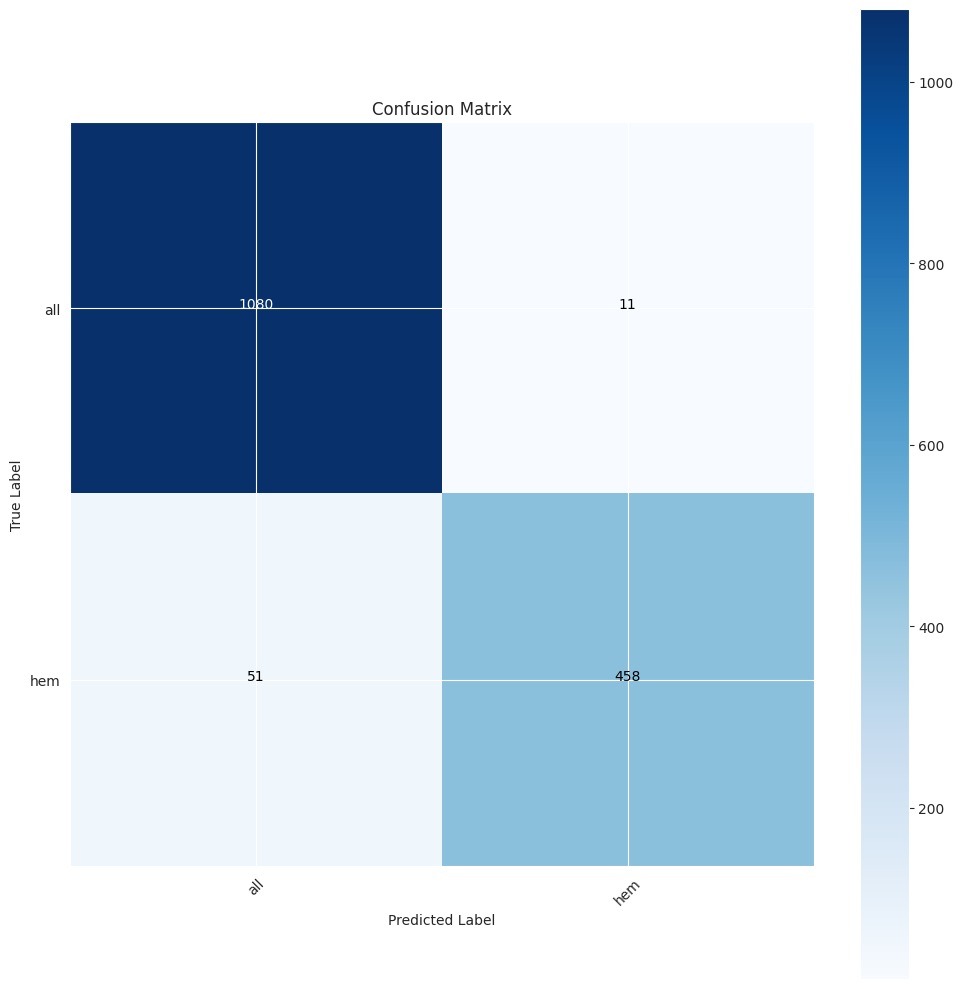

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred1)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred1, target_names= classes))

**Model 02: ResNet50**

Confusion Matrix, Without Normalization
[[1043   48]
 [  42  467]]
              precision    recall  f1-score   support

         all       0.96      0.96      0.96      1091
         hem       0.91      0.92      0.91       509

    accuracy                           0.94      1600
   macro avg       0.93      0.94      0.94      1600
weighted avg       0.94      0.94      0.94      1600



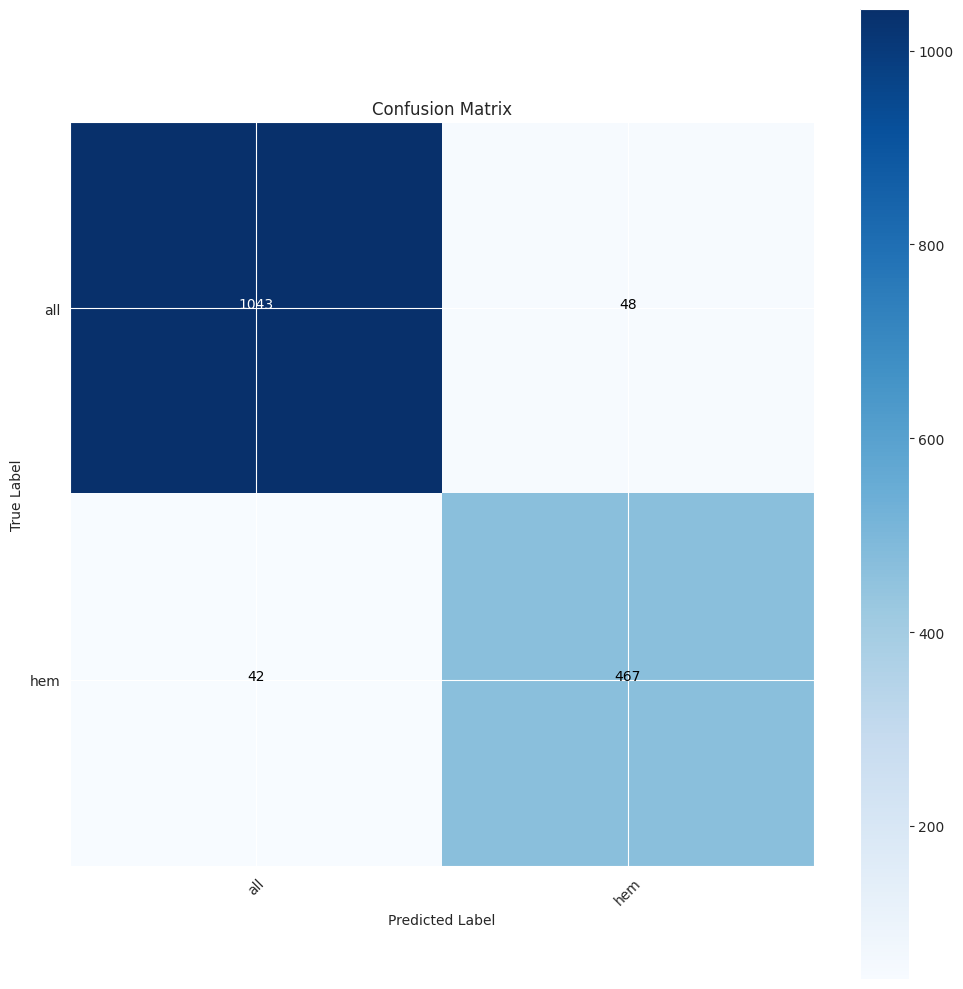

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred2)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred2, target_names= classes))

**Model 03: VGG16**

Confusion Matrix, Without Normalization
[[1090    1]
 [ 464   45]]
              precision    recall  f1-score   support

         all       0.70      1.00      0.82      1091
         hem       0.98      0.09      0.16       509

    accuracy                           0.71      1600
   macro avg       0.84      0.54      0.49      1600
weighted avg       0.79      0.71      0.61      1600



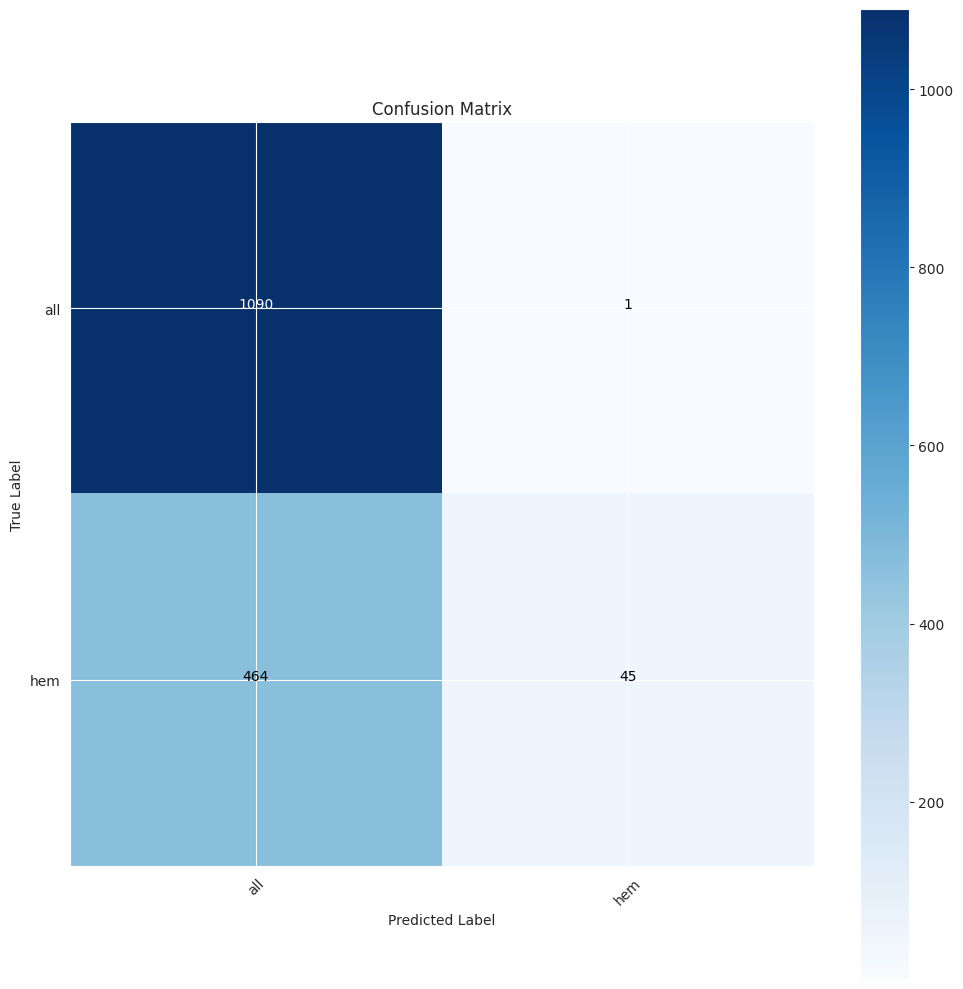

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred3)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred3, target_names= classes))

**Model 03: ALEXNET**

Confusion Matrix, Without Normalization
[[604 487]
 [ 72 437]]
              precision    recall  f1-score   support

         all       0.89      0.55      0.68      1091
         hem       0.47      0.86      0.61       509

    accuracy                           0.65      1600
   macro avg       0.68      0.71      0.65      1600
weighted avg       0.76      0.65      0.66      1600



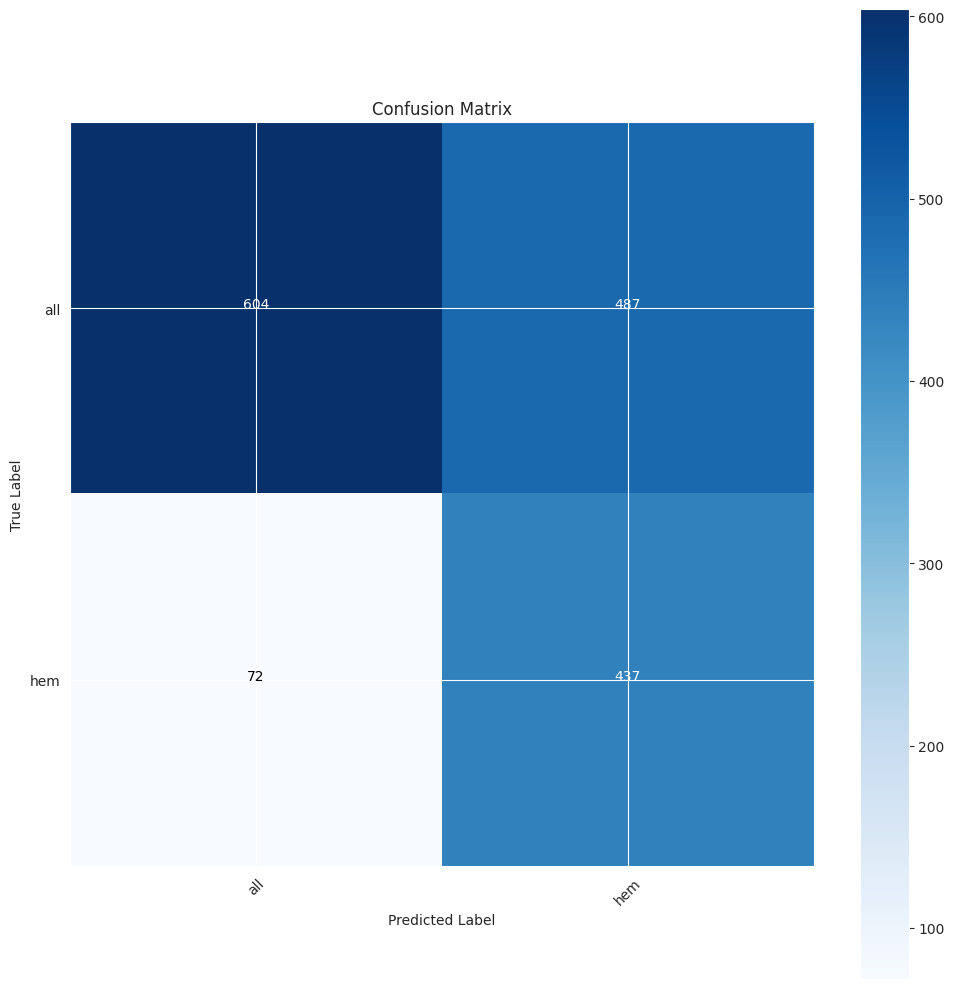

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred4)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred4, target_names= classes))

###***Reading Input***

In [ ]:
img_path=r'../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/all/UID_11_10_1_all.bmp'

In [ ]:
def process_input(img_path):
  img=plt.imread(img_path)
  print ('Input image shape is ', img.shape)
  img_size = (224, 224)
  img=cv2.resize(img, img_size)
  print ('the resized image has shape ', img.shape)
  plt.axis('off')
  plt.imshow(img)
  img=np.expand_dims(img, axis=0)
  print ('image shape after expanding dimensions is ',img.shape)
  # now predict the image
  preds = model2.predict_generator(img)
  y_pred1 = np.argmax(preds, axis=1)
  y_pred1txt = ""
  if y_pred1[0] == 0:
    y_pred1txt = 'CELL IS LEUKEMIC'
  elif y_pred1[0] == 1:
    y_pred1txt = 'NORMAL CELL'
  print("Prediction : ",y_pred1txt)
  pred=model2.predict(img)
  print ('the shape of prediction is ', pred.shape)
  index=np.argmax(pred[0])
  klass=train_gen[index]
  probability=pred[0][index]*100
  print(f'the image is predicted as being {klass} with a probability of {probability:6.2f} %')
  return y_pred1

Input image shape is  (450, 450, 3)
the resized image has shape  (224, 224, 3)
image shape after expanding dimensions is  (1, 224, 224, 3)
Prediction :  CELL IS LEUKEMIC
1/1 [==============================] - 0s 23ms/step
the shape of prediction is  (1, 2)
the image is predicted as being (array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ..

array([0])

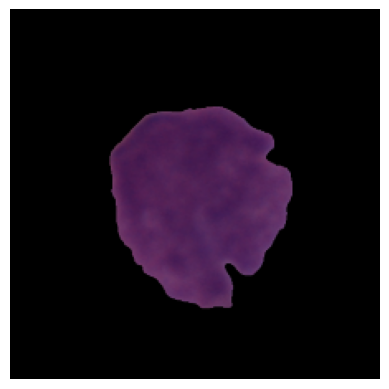

In [ ]:
process_input(img_path)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('/content/drive/MyDrive/ALL_MINI_Folder/ResNet50/ResNet50_model2.h5')

# Print the summary of the model to understand its architecture
model.summary()

# To get the number of features, we'll inspect the input layer
# Assuming the first layer is the input layer and has input shape defined

input_shape = model.layers[0].input_shape

# If input_shape is a tuple (None, number_of_features) or (batch_size, number_of_features)
# we need to extract the second value

if isinstance(input_shape, list):
    input_shape = input_shape[0]
    print(f"Input shape: {input_shape}")
else:
    print(f"Input shape: {input_shape}")

number_of_features = input_shape[1]

print(f"Number of features: {number_of_features}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 24120962 (92.01 MB)
Trainable params: 24063746 (91.80 MB)
Non-trainable params: 57216 (223.50 KB)
__________